# ✳ Neural Training Algorithm
## ✅ 학습 알고리즘 구현하기 
### ▶ 신경망 학습의 절차
**전제**
#### 신경망에는 적응 가능한 가중치(weight)와 편향(bias)이 있고, 이 가중치와 편향을 휸련 데이터에 적응하도록 조정하는 과정을 '학습' 이라고 한다.

**1️⃣ 1단계 - 미니배치**
#### 훈련 데이터 중 일부를 무작위로 가져온다.
#### 무작위로 선별한 데이터 ➡ 미니배치
#### 우리는 이 미니배치의 손실함수값을 줄이는 것을 목표로 한다.

**2️⃣ 2단계 - 기울기 산출**
#### 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다.
#### 기울기는 손실 함수의 값을 가장 작게 하는 방향으로 제시

**3️⃣ 3단계 - 매개변수 갱신**
#### 가중치 매개변수를 기울기 방향으로 아주 조금 갱신

**4️⃣ 4단계 - 반복**
#### 1~3단계를 반복

- 경사 하강법으로 매개변수를 갱신 + 데이터를 미니배치로 무작위 선정
➡ **확률적 경사 하강법 (stochastic gradient descent, SGD)**

### ▶ 2층 신경망 클래스 구현하기
- 2층 신경망을 하나의 class로 구현 (TwoLayerNet class)

In [3]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    # 가중치 초기화
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {} # 신경망의 매개변수
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        
        self.params['b2'] = np.zeros(output_size)
    
    # 에측 실행
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b2'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        
        a2 = np.dot(z1, W2) + b2
        
        y = softmax(a2)
        return y
    
    # 손실 함수
    def loss(self, x, t): # x : input data / t : true label
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    # 정확도
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        y = np.argmax(t, axis=2)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # 가중치 매개변수의 기울기
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {} # 기울기
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    

### ▶ 미니배치 학습 구현하기
- 훈련 데이터 중 일부를 무작위로 꺼내고(미니배치)
- 그 미니배치에 대해 경사법으로 매개변수를 갱신

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)

train_loss_list = []

# hyper parameter
iters_num = 10000 # 학습 반복 획수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치의 크기
learning_rate = 0.1

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 성능 개선판
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

### ▶ 시험 데이터로 평가하기
1. 훈련 데이터의 손실함수 값이 작아지는지 확인 ➡ 신경망이 잘 학습중
2. 훈련데이터 외의 데이터를 올바르게 인식하는지 확인 ➡ overfitting을 일으키지 않는지
**1epoch 단위로 훈련 데이터와 시험데이터에 대한 정확도 기록**
(1epoch : 학습에서 훈련데이터와 시험데이터를 모두 소진했을 때의 횟수)

In [14]:
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet
import matplotlib.pyplot as plt

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# ******1epoch 당 반복횟수******
iter_per_epoch = max(train_size / batch_size, 1)

# hyper parameter
iters_num = 10000
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 성능 개선판
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # ******1epoch 당 정확도 계산******
    if i % iter_per_epoch == 0: # 1epoch 마다 실행
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        # print("train acc, test acc | ", str(train_acc),",",str(test_acc))

# graph
'''
x1 = np.arange(0, len(train_acc_list))
y1 = train_acc_list

x2 = np.arange(0, len(test_acc_list))
y2 = test_acc_list
plt.plot(x1, y1, x2, y2)
plt.show()
'''

'\nx1 = np.arange(0, len(train_acc_list))\ny1 = train_acc_list\n\nx2 = np.arange(0, len(test_acc_list))\ny2 = test_acc_list\nplt.plot(x1, y1, x2, y2)\nplt.show()\n'

####   
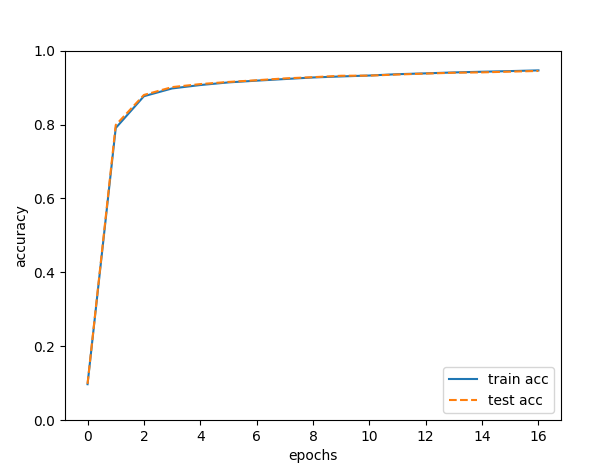
####   

- 만약 overfitting이 일어난다면?
    - 특정 순간부터 정확도가 떨어지는 현상 발생
    - overfitting이 발생한 순간을 포착하여 학습을 중단 (early stopping)
    - 가중치 감수, 드롭아웃 등의 방식도 있음

### 정리
- dataset = 훈련 데이터 + 시험 데이터
- 훈련 데이터에서 학습한 모델의 범용 능력을 시험 데이터로 평가
- 신경망 학습은 손실 함수를 지표로, 손실함수의 값이 작아지는 방향으로 가중치 매개변수 갱신
- 가중치 매개변수를 갱신할 때는 가중치 매개변수의 기울기 이용. 기울어진 방향으로 가중치 값 갱신
- 수치 미분을 이용하여 가중치 매개변수의 기울기 도출
- 수치 미분을 이용한 도출은 간단하지만 시간이 걸림, 반면 오차역전파법으로는 복잡하지만 고속으로 기울기를 구할 수 있음